# Autonomous Vehicle Learning Curve Estimate

This notebook estimates the learning curve for unstructured terrain autonomous vehicles.  The analysis uses the incident rate for on-road autononmous vehicles to estimate the incident rate for off-road AVs.

The on-road AV data is made public by the California DMV.

In [51]:
import os
import numpy as np
import pandas as pd
from scipy import stats
import plotly.express as px
import plotly.graph_objects as go
from IPython.display import Image

## The Learning Curve

We can estimate the learning curve (i.e. the number of incidents per hour driven in the field) from the DMV data.  The following chart summarizes the miles driven by AV manufacturer in 2020 along with the miles driven between incidents.

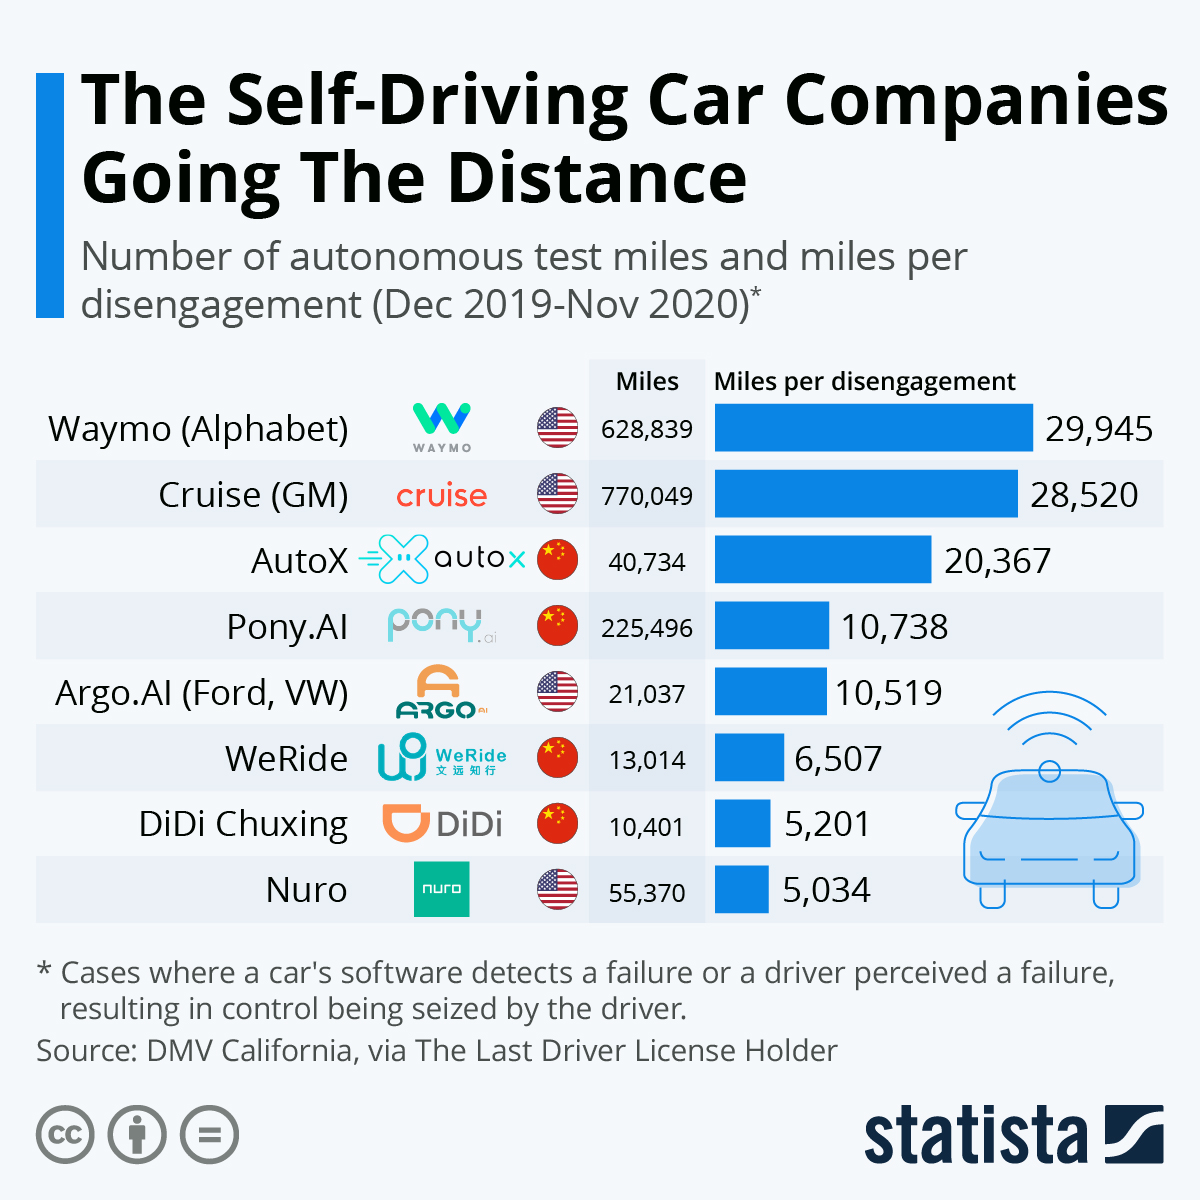

In [2]:
file_name = '17144.jpeg'
Image(filename=file_name) 

### Data Cleansing

We can remove the highest performing AV makers from the mix. The Chinese AV makers in particular are probably gaining experience outside of California and this presents unrealistic intervention rates.

In [3]:
# worst case incidents / mile driven
miles = [#(628839, 29945),
         (770049, 28520),
         (225496, 10738),
        (55370,5034),
         #(40734,20367),
         #(21037,10519),
         (13014,6507),
         (10401,5201),
        ]
miles = sorted(miles, key=lambda k:k[0])
df = pd.DataFrame(miles, columns=['miles','miles_between_interventions'])

# Assumption

We can assume an average speed of 15 mph to translate the miles driven into hours of operation (a more relevant metric for off-road vehicles given the reduced speed).  From the hours of operation, we can compute the mean time between failures (MTBF):


In [4]:
df['hours'] = df['miles'] / 15
df['mtbf'] = df['miles_between_interventions'] / 15
df

,miles,miles_between_interventions,hours,mtbf
0,10401,5201,693.400000,346.733333
1,13014,6507,867.600000,433.800000
2,55370,5034,3691.333333,335.600000
3,225496,10738,15033.066667,715.866667
4,770049,28520,51336.600000,1901.333333


In [26]:
fig = px.scatter(df, 
                 x='hours',
                 y='mtbf',
                 trendline="ols",
                 title='Mean Time Between Failures (Human Interventions)<br>vs Hours Driven in the Field'
                )
fig.show()
results = px.get_trendline_results(fig)
#results.iloc[0].values[0].summary()

/opt/local/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/stats/stattools.py:74: ValueWarning:

omni_normtest is not valid with less than 8 observations; 5 samples were given.



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.988
Model:                            OLS   Adj. R-squared:                  0.984
Method:                 Least Squares   F-statistic:                     252.8
Date:                Tue, 30 Aug 2022   Prob (F-statistic):           0.000541
Time:                        09:14:09   Log-Likelihood:                -27.911
No. Observations:                   5   AIC:                             59.82
Df Residuals:                       3   BIC:                             59.04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        307.3601     46.267      6.643      0.007     160.119     454.602
x1             0.0307      0.002     15.898      0.001       0.025       0.037
==============================================================================
Omnibus:                          nan   Durbin-Watson:                   2.279
Prob(Omnibus):                    nan   Jarque-Bera (JB):                0.297
Skew:                           0.188   Prob(JB):                        0.862
Kurtosis:                       1.867   Cond. No.                     2.99e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.99e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Learning Curve Equation

From the above data, we get the following learning curve equation:

$$
MTBF = .03 \times h + 307
$$

where:  
$MTBF$ Mean time between failure (or human interventions)  
$h$ is the cumulative number hours of experience

In [6]:
reg = stats.linregress(x=df['hours'],y=df['mtbf'])
reg

LinregressResult(slope=0.030668408690463, intercept=307.3601132209984, rvalue=0.9941178290443223, pvalue=0.0005410741191069168, stderr=0.0019290211148771308, intercept_stderr=46.26675062842805)

## Learning curve

Let's assumes the following number of tractors will ship over time:

Year | count
--|--
2022 | 1
2023 | 33
2024 | 161
2025 | 585
2026 | 1585
2027 | 6000
2028 | 15000

The following is an estimate of the cost per tractor unit:

In [7]:
tractor_count = [2, 33, 161, 585, 1585, 6000,15000]
tractor_cost = [35000,29000,23000,20000,17500,12500,9500]

### Assumptions

Let's assume an autonomous tractor in production has the following operating profile:

- hours per day: 8
- days per week: 7
- unit forecast (see above)
- the opex is ~ 300 USD per month or 3,600 USD / year

In [41]:
cum_count = 0
cum_hours = 0
learnings = 0
rpt = []
for i,n in enumerate(tractor_count):
    cost = tractor_cost[i]
    cum_count += int((n / 2))
    hours = cum_count * 8 * 52 * 7
    cum_hours += hours
    
    mtbf = reg.slope * cum_hours + reg.intercept
    learnings += hours / mtbf
    opex = 3600
    r= {'year':i + 2022,
        'count':n,
        'cum_count':cum_count,
        'hours': hours,
        'cum_hours': cum_hours,
        'mtbf': mtbf,
        'learnings': int(learnings),
        'cost_per_tractor':cost,
        'capex': cost * n,
        'opex': opex,
}
    rpt += [r]
a = pd.DataFrame(rpt)
a

,year,count,cum_count,hours,cum_hours,mtbf,learnings,cost_per_tractor,capex,opex
0,2022,2,1,2912,2912,3.966665e+02,7,35000,70000,3600
1,2023,33,17,49504,52416,1.914875e+03,33,29000,957000,3600
2,2024,161,97,282464,334880,1.057760e+04,59,23000,3703000,3600
3,2025,585,389,1132768,1467648,4.531779e+04,84,20000,11700000,3600
4,2026,1585,1181,3439072,4906720,1.507887e+05,107,17500,27737500,3600
5,2027,6000,4181,12175072,17081792,5.241787e+05,130,12500,75000000,3600
6,2028,15000,11681,34015072,51096864,1.567367e+06,152,9500,142500000,3600


In [9]:
# Cost of Operation

In [42]:
a['investment'] = a['capex'] + a['opex']
a['cum_investment'] = a['investment'].cumsum()
a['cost_per_learning'] = a['cum_investment'] / a['learnings']
a

,year,count,cum_count,hours,cum_hours,mtbf,learnings,cost_per_tractor,capex,opex,investment,cum_investment,cost_per_learning
0,2022,2,1,2912,2912,3.966665e+02,7,35000,70000,3600,73600,73600,1.051429e+04
1,2023,33,17,49504,52416,1.914875e+03,33,29000,957000,3600,960600,1034200,3.133939e+04
2,2024,161,97,282464,334880,1.057760e+04,59,23000,3703000,3600,3706600,4740800,8.035254e+04
3,2025,585,389,1132768,1467648,4.531779e+04,84,20000,11700000,3600,11703600,16444400,1.957667e+05
4,2026,1585,1181,3439072,4906720,1.507887e+05,107,17500,27737500,3600,27741100,44185500,4.129486e+05
5,2027,6000,4181,12175072,17081792,5.241787e+05,130,12500,75000000,3600,75003600,119189100,9.168392e+05
6,2028,15000,11681,34015072,51096864,1.567367e+06,152,9500,142500000,3600,142503600,261692700,1.721662e+06


## Conclusions

As Arcadia ships more units in the field it gains operating hours and over time it runs into field issues (i.e. learnings) at a rate prescribed by the learning curve.  As the frequency of incidents decreases, each learning becomes more valuable:

In [43]:
fig = px.bar(a, 
             x='year', 
             y='cost_per_learning',
             title='Avg Cost per New Learning over Time').show()

In [12]:
# cost to catch up

### Cost to Catch Up

As Arcadia gains experience in the field, it becomes more and more difficult for other firms to catch up.  If we estimate that a competitor trying to pivot would take 18 to 24 months to effect the pivot, the cost of catching up (excluding the R&D investment) is shown below. This cost includes the CapEx to build tractors and the Opex to run tractors in the field.  This number also assumes competitors have the same learning curve as Arcadia.

In [53]:
a['cost_to_catch_up'] = a['cum_investment'].shift(-2)
a['best_case_competitor_hours'] = a['cum_hours'].shift(2)
fig = px.bar(a.head(5), 
             x='year', 
             y='cost_to_catch_up',
             title='Field Investment Required (USD) to Catch Up').show()

### Data Advantage

In 2023, Arcadia will have 300k hours of field experience before competitors are even out of the gate.  To catch-up, competitors would have to:

1. pursuade partners willing to spend time running a new solution (a difficult task when a working solution is already available), and
2. invest $50M in field operations

The competitive gap would go up non-linearly -- i.e. every year the number of hours required goes up exponentially.

In [57]:
fig = go.Figure()
# Create and style traces
fig.add_trace(go.Scatter(x=a['year'], y=a['cum_hours'], name='Arcadia',
                         line=dict(color='royalblue', width=4)))

fig.add_trace(go.Scatter(x=a['year'], y=a['best_case_competitor_hours'], name='Others',
                         line=dict(color='firebrick', width=4)))

# Edit the layout
fig.update_layout(title='Unstructured Terrain<br>Operating Hours',
                   xaxis_title='Year',
                   yaxis_title='Field Operating Hours')


fig.show()